In [59]:
import numpy as np
import importlib
import three_cart.simulator as sim
np.set_printoptions(precision=3, suppress=True)
import matplotlib.pyplot as plt
import torch 
import time
from torch.autograd import Variable
import torch.optim as optim
torch.set_printoptions(precision=3, sci_mode=False)
%precision 3

'%.3f'

In [101]:
importlib.reload(sim)

<module 'three_cart.simulator' from '/home/felix/soft_contact/three_cart/simulator.py'>

# Predefined inputs

In [102]:
def simulate(simulator, init_state, inputs):
    # recorder trajectories
    timesteps = inputs.shape[1]
    x_trajectory = np.zeros((6, timesteps))
    x_trajectory[:,0] = init_state
    lambda_trajectory = np.zeros((2, timesteps))
    # forward simulate
    simulator.set_state(init_state)
    for t in range(inputs.shape[1]):
        simulator.step(inputs[:, t]) # Control input
        x_trajectory[:,t] = simulator.get_state()
        lambda_trajectory[:,t] = simulator.get_contact()
    return x_trajectory, lambda_trajectory

In [172]:
# hyper params set 1
timesteps = 500
init_state = np.array([1, 0, 3, 0, 4, 0]).astype(np.double)
inputs = np.array([[1, -1] for i in range(timesteps)]).T
params = {'m': 1.,  # mass
          'c': 2.0,  # viscosity
          'k': 30.0,  # elasticity
          'd': 0.5,    # cart length
          'w': 0.5,    # cart height (just for visualization) 
          'h': 0.01,   # time step
          't': 0.005}   # sleep time before redrawing on canvas

## Simulate with predefined inputs

In [173]:
try:
    C.tk.destroy()
except:
    pass
C = sim.CartSimulator(gui=True, video=True)
for key, value in params.items():
    C.set_parameters(key, value)
x_trajectory, lambda_trajectory = simulate(C, init_state, inputs)

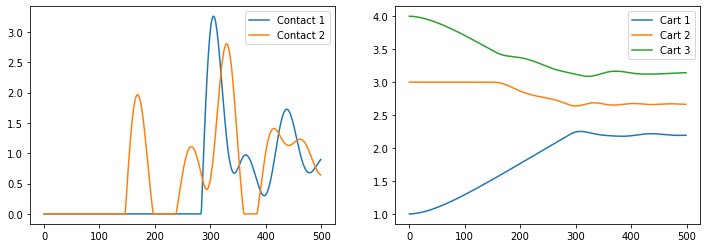

In [105]:
# plotting
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1,2,1)
ax.plot(range(timesteps), lambda_trajectory[0,:])
ax.plot(range(timesteps), lambda_trajectory[1,:])
ax.legend(['Contact 1', 'Contact 2'])
ax = fig.add_subplot(1,2,2)
ax.plot(range(timesteps), x_trajectory[0,:])
ax.plot(range(timesteps), x_trajectory[2,:])
ax.plot(range(timesteps), x_trajectory[4,:])
ax.legend(['Cart 1', 'Cart 2', 'Cart 3'])

In [106]:
goal_state = C.get_state()
goal_state

array([ 2.194,  0.021,  2.664, -0.017,  3.142, -0.005])

In [107]:
C.tk.destroy()

# Single Shooting to find inputs

In [108]:
# tensorized version of cart simulator class
class CartSimTensorized(sim.CartSimulator):
    def __init__(self, timesteps, params):
        super(CartSimTensorized, self).__init__(gui=False, video=False)
        self.timesteps = timesteps
        self.goal_state = torch.zeros(6).double()
        self.states = torch.zeros(6, self.timesteps+1).double()
        self.forces = torch.zeros(2, self.timesteps).double()
        for key, value in params.items():
            self.set_parameters(key, value)

    def set_states(self, state, t):
        assert len(state) == 6
        self.states[:, t] = torch.tensor(state).double() #automatically creates a copy

    # Semi-implicit time-stepping for dynamics integration
    def forward_pass(self, inputs):
        # forward integrate to obtain a target state
        for t in range(self.timesteps):
            # Compute contact forces first
            lambda1 = torch.nn.ReLU()(-self.params['k'] * (self.states[2,t] - self.states[0,t] - self.params['d']))
            lambda2 = torch.nn.ReLU()(-self.params['k'] * (self.states[4,t] - self.states[2,t] - self.params['d']))
            self.forces[:,t] = torch.stack([lambda1, lambda2]).double().detach()

            # Propagate velocities ### EXAMINE HERE IF LAMBDA1 CAN BE USED
            self.states[1,t+1] = self.states[1,t] + self.params['h'] * \
                                (-self.params['c'] * self.states[1,t] - lambda1 + inputs[0,t])
            self.states[3,t+1] = self.states[3,t] + self.params['h'] * \
                                (-self.params['c'] * self.states[3,t] + lambda1 - lambda2)
            self.states[5,t+1] = self.states[5,t] + self.params['h'] * \
                                (-self.params['c'] * self.states[5,t] + lambda2 + inputs[1,t])

            # Propagate positions at t with velocities at t+1
            self.states[[0,2,4],t+1] = self.states[[0,2,4],t] + self.params['h'] * self.states[[1,3,5],t+1]
            
        return self.states[:, -1] 

## Update params to make optimization horizon shorter

In [202]:
# obtain goal states from simulation with predefined inputs
print(goal_state)
print(init_state)
goal_state = torch.tensor(goal_state)
goal_state = torch.tensor([1.5, 0, 2.5, 0, 3.5, 0])
init_state = torch.tensor(init_state)
# CSGD.set_states(init_state, 0)

tensor([1.500, 0.000, 2.500, 0.000, 3.500, 0.000])
tensor([1., 0., 3., 0., 4., 0.], dtype=torch.float64)


/home/felix/.envs/habitatenv/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/home/felix/.envs/habitatenv/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [203]:
# inputs candidate 1 
guess_inputs = np.array([[0, 0] for i in range(timesteps)]).T

# inputs candidata 2
# guess_inputs = np.random.uniform(-100, 100, (2, timesteps))

In [204]:
# training procedure 
# training hyper params
lr = 500
epochs = 100
input_loss_weight = 0.00005

# training stepup
guess_inputs = torch.tensor(guess_inputs, requires_grad=True, dtype=torch.double)
optimizer = optim.SGD([guess_inputs], lr=lr)
losses = np.zeros(epochs)
#record time
since = time.time()

# start training 
for epoch in range(epochs):
    CSGD = CartSimTensorized(timesteps, params)
    CSGD.set_states(init_state, 0)
    final_state = CSGD.forward_pass(guess_inputs)
    # terminal loss
    terminal_loss = ((final_state - goal_state)**2).mean()
    # input L2 regulation
    input_loss = torch.sum(guess_inputs * guess_inputs)
    # total loss
    loss = terminal_loss + input_loss_weight*input_loss
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses[epoch] = loss.data.numpy()
    if True :
        print('loss: ', '{:.3f}'.format(loss.data.numpy()))

time_elapsed = time.time() - since
print('Training takes in {:.0f}m {:.0f}s'.format(time_elapsed // 60,
                                                time_elapsed % 60))
    

/home/felix/.envs/habitatenv/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


loss:  0.125
loss:  0.058
loss:  0.049
loss:  0.042
loss:  0.038
loss:  0.034
loss:  0.032
loss:  0.030
loss:  0.028
loss:  0.027
loss:  0.026
loss:  0.025
loss:  0.025
loss:  0.024
loss:  0.024
loss:  0.023
loss:  0.023
loss:  0.023
loss:  0.023
loss:  0.022
loss:  0.022
loss:  0.022
loss:  0.022
loss:  0.022
loss:  0.021
loss:  0.021
loss:  0.021
loss:  0.021
loss:  0.021
loss:  0.021
loss:  0.021
loss:  0.021
loss:  0.020
loss:  0.020
loss:  0.020
loss:  0.020
loss:  0.020
loss:  0.020
loss:  0.020
loss:  0.020
loss:  0.020
loss:  0.020
loss:  0.020
loss:  0.020
loss:  0.020
loss:  0.020
loss:  0.019
loss:  0.019
loss:  0.019
loss:  0.019
loss:  0.019
loss:  0.019
loss:  0.019
loss:  0.019
loss:  0.019
loss:  0.019
loss:  0.019
loss:  0.019
loss:  0.019
loss:  0.019
loss:  0.019
loss:  0.019
loss:  0.019
loss:  0.019
loss:  0.019
loss:  0.019
loss:  0.019
loss:  0.019
loss:  0.018
loss:  0.018
loss:  0.018
loss:  0.018
loss:  0.018
loss:  0.018
loss:  0.018
loss:  0.018
loss:  0.018

In [151]:
guess_inputs

tensor([[     0.249,      0.249,      0.249,      0.249,      0.249,      0.249,
              0.249,      0.249,      0.249,      0.249,      0.249,      0.249,
              0.249,      0.249,      0.249,      0.249,      0.249,      0.249,
              0.249,      0.249,      0.249,      0.249,      0.249,      0.249,
              0.249,      0.249,      0.249,      0.249,      0.249,      0.249,
              0.249,      0.249,      0.249,      0.249,      0.249,      0.249,
              0.249,      0.249,      0.249,      0.249,      0.249,      0.249,
              0.249,      0.249,      0.249,      0.249,      0.249,      0.249,
              0.249,      0.249,      0.249,      0.249,      0.249,      0.249,
              0.249,      0.249,      0.249,      0.249,      0.249,      0.249,
              0.249,      0.249,      0.249,      0.249,      0.249,      0.249,
              0.249,      0.249,      0.249,      0.249,      0.249,      0.249,
              0.249,      0.

In [205]:
try:
    C.tk.destroy()
except:
    pass
C = sim.CartSimulator(gui=True, video=True)
for key, value in params.items():
    C.set_parameters(key, value)
x_trajectory, lambda_trajectory = simulate(C, init_state.numpy(), guess_inputs)

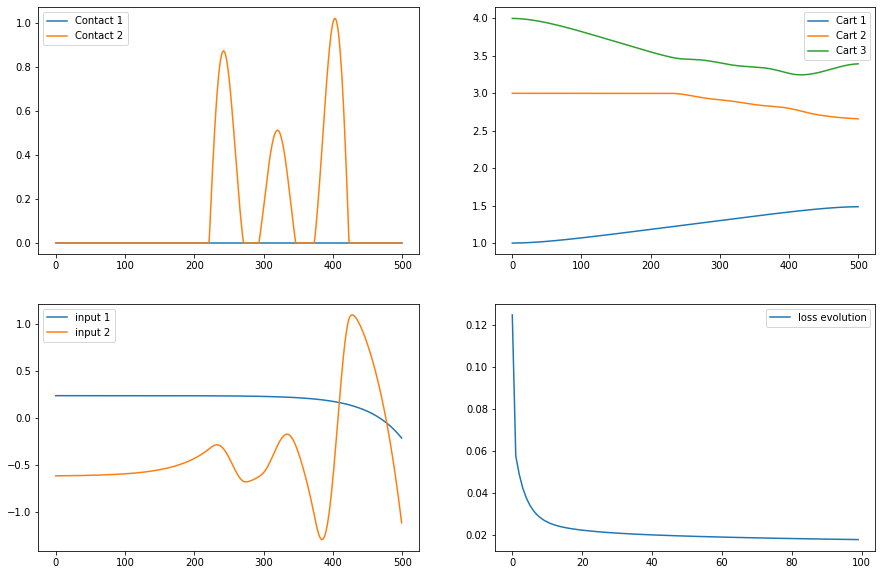

In [206]:
plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
plt.plot(range(timesteps), CSGD.forces[0,:])
plt.plot(range(timesteps), CSGD.forces[1,:])
plt.legend(['Contact 1', 'Contact 2'])
plt.subplot(2,2,2)
plt.plot(range(timesteps+1), CSGD.states[0,:].detach())
plt.plot(range(timesteps+1), CSGD.states[2,:].detach())
plt.plot(range(timesteps+1), CSGD.states[4,:].detach())
plt.legend(['Cart 1', 'Cart 2', 'Cart 3'])
plt.subplot(2,2,3)
plt.plot(range(timesteps), guess_inputs[0,:].detach())
plt.plot(range(timesteps), guess_inputs[1,:].detach())
plt.legend(['input 1', 'input 2'])
plt.subplot(2,2,4)
plt.plot(range(epochs), losses)
plt.legend(['loss evolution'])
plt.show()

In [93]:
C.tk.destroy()

In [207]:
C.save_video('sgd.avi')